<a href="https://colab.research.google.com/github/Jeoungeunseok/ai-breach-of-contract-model/blob/main/%EC%8A%A4%ED%8C%8C%EB%A5%B4%ED%83%80%EC%BD%94%EB%94%A9_AI%EC%97%94%EC%A7%80%EB%8B%88%EC%96%B44%EA%B8%B0_250719_%EC%A0%95%EC%9D%80%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요한 라이브러리 설치

In [ ]:
# !pip install scikit-learn==1.3.2 xgboost==2.1.0 torch==2.3.1

In [ ]:
# 2. 라이브러리 import
# 데이터 처리 및 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 머신러닝 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# PyTorch (선택적 사용 시)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

### 데이터 불러오기 및 확인 (테스트)

In [ ]:
# GPU 사용 가능하면 GPU, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 현재 사용 중인 연산 장치: {device}")

# CSV 파일 경로
data_path = "./sample_data/Loan_Default.csv"

# 데이터 로드
df = pd.read_csv(data_path)

✅ 현재 사용 중인 연산 장치: cuda


In [ ]:
# 데이터 확인
print("✅ 데이터셋 크기:", df.shape)
print("✅ 컬럼 정보:")
print(df.columns)

# 상위 5개 미리 보기
df.head()

✅ 데이터셋 크기: (148670, 34)
✅ 컬럼 정보:
Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


## 데이터 전처리를 위한 클래스 구성

In [ ]:
class BinomialClassificationDataLoader:
    def __init__(self, file_path, label_col='Status', test_size=0.2, val_size=0.2, random_state=42):
        self.file_path = file_path
        self.label_col = label_col
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.df = None
        self.X = None
        self.y = None
        self.X_train = self.X_val = self.X_test = None
        self.y_train = self.y_val = self.y_test = None
        self.scaler = None
        self.imputer = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        original_shape = self.df.shape
        self.df.drop_duplicates(inplace=True)
        cleaned_shape = self.df.shape
        print(f'원래 shape: {original_shape} → 중복 제거 후: {cleaned_shape}')
        print('컬럼 정보:')
        print(self.df.dtypes)

    def show_label_distribution(self):
        label_counts = self.df[self.label_col].value_counts()
        print('라벨 분포:')
        print(label_counts)
        sns.countplot(x=self.df[self.label_col])
        plt.title('Label Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.show()

    def separate_features_and_label(self):
        self.y = self.df[self.label_col]
        self.X = self.df.drop(columns=[self.label_col])
        print(f'X shape: {self.X.shape}, y shape: {self.y.shape}')

    def encode_categorical(self):
        cat_cols = self.X.select_dtypes(include='object').columns
        if len(cat_cols) > 0:
            print(f'인코딩할 범주형 컬럼: {list(cat_cols)}')
            self.X = pd.get_dummies(self.X, columns=cat_cols, drop_first=True)
        self.encoded_columns = self.X.columns.tolist()

    def show_missing_summary(self, return_columns=False):
        missing_cols = self.df.columns[self.df.isnull().any()]
        label_col = self.label_col
        drop_cols = set()
        total_rows = len(self.df)
        print('[결측치 요약 및 삭제 후보 컬럼]')
        for col in missing_cols:
            grouped = self.df.groupby(label_col)[col].apply(lambda x: x.isnull().sum())
            total_missing = self.df[col].isnull().sum()
            missing_rate = total_missing / total_rows * 100
            print(f"'{col}': 총 결측치 {total_missing}개 ({missing_rate:.2f}%)")
            if (grouped == 0).sum() == 1:
                class_only = grouped[grouped > 0].index[0]
                print(f'   한쪽 클래스({class_only})에만 결측치 존재')
                if class_only == 1:
                    drop_cols.add(col)
                    print('   삭제 대상 컬럼으로 추가됨')
            print()
        print(f'삭제 대상 컬럼 수: {len(drop_cols)}개')
        print(f'삭제 대상 목록: {list(drop_cols)}')
        if return_columns:
            return list(drop_cols)

    def handle_outliers(self, quantile=0.01):
        print('이상치 제거 시작 (IQR 방식)')
        print('Before:', self.df.shape)
        numeric_cols = self.df.select_dtypes(include=np.number).columns
        numeric_cols = [col for col in numeric_cols if col not in ['ID', 'year']]
        outlier_indices = set()
        for col in numeric_cols:
            q_low = self.df[col].quantile(quantile)
            q_high = self.df[col].quantile(1 - quantile)
            outliers = self.df[(self.df[col] < q_low) | (self.df[col] > q_high)].index
            outlier_indices.update(outliers)
        self.df = self.df.drop(index=list(outlier_indices)).reset_index(drop=True)
        print('After:', self.df.shape)

    def split_data(self):
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state, stratify=self.y
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=self.val_size, random_state=self.random_state, stratify=y_temp
        )
        print(f'Data split 완료:')
        print(f'Train: {self.X_train.shape}, Validation: {self.X_val.shape}, Test: {self.X_test.shape}')

    def handle_missing(self, strategy='mean'):
        for name, data in zip(['Train', 'Val', 'Test'], [self.X_train, self.X_val, self.X_test]):
            n_missing = np.isnan(data).sum() if isinstance(data, np.ndarray) else data.isnull().values.sum()
            if n_missing > 0:
                print(f"{name} 결측치 수: {n_missing}")

        if strategy == 'mean':
            self.imputer = SimpleImputer(strategy='mean')
        elif strategy == 'median':
            self.imputer = SimpleImputer(strategy='median')
        elif strategy == 'zero':
            self.imputer = SimpleImputer(strategy='constant', fill_value=0)
        else:
            raise ValueError("지원되지 않는 전략입니다")

        # Train 기준으로 fit → 나머지는 transform
        self.X_train = self.imputer.fit_transform(self.X_train)
        self.X_val = self.imputer.transform(self.X_val)
        self.X_test = self.imputer.transform(self.X_test)

        print('결측치 보강 완료 (Train 기준으로 fit)')

    def scale_features(self):
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_val = self.scaler.transform(self.X_val)
        self.X_test = self.scaler.transform(self.X_test)
        print('스케일링 완료 (Train 기준 fit)')

class ImbalancedDataLoader(BinomialClassificationDataLoader):
    def apply_undersampling(self):
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=self.random_state)
        self.X_train, self.y_train = rus.fit_resample(self.X_train, self.y_train)
        print(f'언더샘플링 완료: {pd.Series(self.y_train).value_counts().to_dict()}')

    def apply_oversampling(self):
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=self.random_state)
        self.X_train, self.y_train = ros.fit_resample(self.X_train, self.y_train)
        print(f'오버샘플링 완료: {pd.Series(self.y_train).value_counts().to_dict()}')

## 데이터 전처리 과정 하나씩 보기

## 데이터 로드 및 중복행 제거

In [ ]:
# 인스턴스 생성
loader = ImbalancedDataLoader("./sample_data/Loan_Default.csv")

# 데이터 로드 및 중복행 제거
loader.load_data()

원래 shape: (148670, 34) → 중복 제거 후: (148670, 34)
컬럼 정보:
ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score         

## 데이터 결측치 확인 및 제거

In [ ]:
# 삭제할 컬럼 목록 가져오기
cols_to_drop = loader.show_missing_summary(return_columns=True)

# 컬럼 제거
loader.df = loader.df.drop(columns=cols_to_drop)
print(f"제거된 컬럼 목록: {cols_to_drop}")

[결측치 요약 및 삭제 후보 컬럼]
'loan_limit': 총 결측치 3344개 (2.25%)

'approv_in_adv': 총 결측치 908개 (0.61%)

'loan_purpose': 총 결측치 134개 (0.09%)

'rate_of_interest': 총 결측치 36439개 (24.51%)
   한쪽 클래스(1)에만 결측치 존재
   삭제 대상 컬럼으로 추가됨

'Interest_rate_spread': 총 결측치 36639개 (24.64%)
   한쪽 클래스(1)에만 결측치 존재
   삭제 대상 컬럼으로 추가됨

'Upfront_charges': 총 결측치 39642개 (26.66%)

'term': 총 결측치 41개 (0.03%)

'Neg_ammortization': 총 결측치 121개 (0.08%)

'property_value': 총 결측치 15098개 (10.16%)

'income': 총 결측치 9150개 (6.15%)

'age': 총 결측치 200개 (0.13%)
   한쪽 클래스(1)에만 결측치 존재
   삭제 대상 컬럼으로 추가됨

'submission_of_application': 총 결측치 200개 (0.13%)
   한쪽 클래스(1)에만 결측치 존재
   삭제 대상 컬럼으로 추가됨

'LTV': 총 결측치 15098개 (10.16%)

'dtir1': 총 결측치 24121개 (16.22%)

삭제 대상 컬럼 수: 4개
삭제 대상 목록: ['Interest_rate_spread', 'submission_of_application', 'age', 'rate_of_interest']
제거된 컬럼 목록: ['Interest_rate_spread', 'submission_of_application', 'age', 'rate_of_interest']


## 이상치 제거

In [ ]:
loader.handle_outliers()

이상치 제거 시작 (IQR 방식)
Before: (148670, 30)
After: (134093, 30)


## 데이터 분포 확인

라벨 분포:
Status
0    102883
1     31210
Name: count, dtype: int64


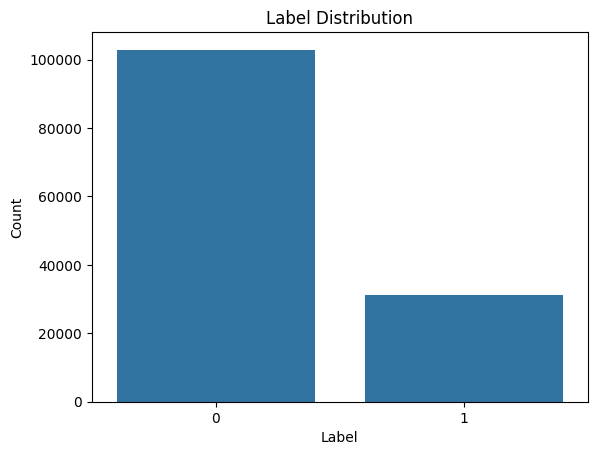

In [ ]:
loader.show_label_distribution()
# 정상 상환자	112,031
# 연체자	36,639

## 데이터 분할

In [ ]:
loader.separate_features_and_label()
# X	입력 데이터 (예측에 사용할 특징들)	고객의 소득, 대출 금액, 이자율 등
# y	타깃 데이터 (우리가 예측하고자 하는 정답)	채무불이행 여부 (Status 컬럼)

X shape: (134093, 29), y shape: (134093,)


## 데이터 인코딩(원핫인코딩)

In [ ]:
loader.encode_categorical()

# loader.X가 numpy array라면 DataFrame으로 변환
# X_encoded_df = pd.DataFrame(loader.X) # 컬럼 붙히지 않고 만들기
X_encoded_df = pd.DataFrame(loader.X, columns=loader.encoded_columns)

# 변환된 데이터 미리 보기 (5행)
X_encoded_df.head()

# 랜덤포레스트를 위한 데이터 정의
classification_feature_names = loader.encoded_columns  # <-- 여기에서 추출

인코딩할 범주형 컬럼: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'Region', 'Security_Type']


## 데이터 학습,테스트,검증 분할

In [ ]:
loader.split_data()
print("Train 라벨 분포:")
print(pd.Series(loader.y_train).value_counts(normalize=True))

print("\nTest 라벨 분포:")
print(pd.Series(loader.y_test).value_counts(normalize=True))

# 전체 데이터는 약 134,093개
# 약 64% Train, 16% Validation, 20% Test 비율로 나뉘어짐
# 각 세트 모두 41개의 특성을 포함
# Status = 1 (채무불이행자)는 전체의 약 23.3%
# Status = 0 (정상 상환자)는 전체의 약 76.7%
# 분포는 Train, Test 모두 거의 동일하게 유지됨

Data split 완료:
Train: (85819, 41), Validation: (21455, 41), Test: (26819, 41)
Train 라벨 분포:
Status
0    0.767254
1    0.232746
Name: proportion, dtype: float64

Test 라벨 분포:
Status
0    0.767255
1    0.232745
Name: proportion, dtype: float64


## 데이터 결측치 보강

In [ ]:
loader.handle_missing()

Train 결측치 수: 58210
Val 결측치 수: 14487
Test 결측치 수: 18120
결측치 보강 완료 (Train 기준으로 fit)


## 데이터 스케일링

In [ ]:
# 1. 스케일링 수행
loader.scale_features()

# 2. 학습 데이터 기준으로 DataFrame 복원
scaled_X_train = pd.DataFrame(loader.X_train, columns=loader.encoded_columns)

# 3. 평균과 표준편차 요약 출력
print('스케일링 후 (Train 기준) 일부 특성 통계:')
print(scaled_X_train.describe().T[['mean', 'std']].head())

# 4. 전체 평균과 표준편차 평균값
print('\n전체 평균 (mean):', np.round(scaled_X_train.mean().mean(), 4))
print('전체 표준편차 (std):', np.round(scaled_X_train.std().mean(), 4))

# 5. 상수 피처 탐지 (std == 0)
stds = scaled_X_train.std()
constant_features = stds[stds == 0].index.tolist()

# 6. 결과 출력
print('\n std = 0 (상수값)인 피처 목록:')
if constant_features:
    for col in constant_features:
        print(f"- {col}")
else:
    print("상수 피처 없음")

print(f'\n총 {len(constant_features)}개의 피처가 상수입니다.')


스케일링 완료 (Train 기준 fit)
스케일링 후 (Train 기준) 일부 특성 통계:
                         mean       std
ID               1.167417e-16  1.000006
year             0.000000e+00  0.000000
loan_amount      4.338484e-17  1.000006
Upfront_charges  5.418966e-17  1.000006
term             8.918732e-16  1.000006

전체 평균 (mean): 0.0
전체 표준편차 (std): 0.9756

 std = 0 (상수값)인 피처 목록:
- year

총 1개의 피처가 상수입니다.


## 학습 데이터에 대해서한 언더 샘플링

In [ ]:
# loader.apply_oversampling()
loader.apply_undersampling()

언더샘플링 완료: {0: 19974, 1: 19974}


## 전처리된 최종 데이터 확인

In [ ]:
# 넘파이 배열을 데이터프레임으로 변환 (입력 피처 + 라벨 합치기)
train_df = pd.DataFrame(loader.X_train)
train_df['Label'] = loader.y_train.reset_index(drop=True)

# 상위 5개 행 미리 보기
print(train_df.head())

print(train_df['Label'].value_counts(normalize=True))

print("Train NaN 존재 여부:", np.isnan(loader.X_train).any())
print("Validation NaN 존재 여부:", np.isnan(loader.X_val).any())
print("Test NaN 존재 여부:", np.isnan(loader.X_test).any())

          0    1         2         3         4         5         6         7  \
0  1.614110  0.0 -0.302779 -1.132291  0.418429 -0.491025  0.001549 -0.185343   
1  0.941334  0.0 -0.114149  2.400446  0.418429 -0.009402 -0.176276  0.526276   
2  0.417838  0.0 -0.994425  0.688698 -2.846706 -0.771972  0.130876  0.122147   
3  0.090921  0.0  0.577496 -0.988306  0.418429  0.231410  0.017715 -0.378623   
4 -0.356967  0.0 -0.805794  0.012037 -0.016922 -0.731837 -0.628920  0.745912   

          8         9  ...        32        33        34        35        36  \
0  0.381609  0.877217  ... -0.040997 -0.646949 -0.334887 -0.623946 -0.996777   
1 -0.468423 -2.016978  ... -0.040997 -0.646949 -0.334887 -0.623946  1.003233   
2 -0.809309 -0.458565  ... -0.040997 -0.646949 -0.334887  1.602702  1.003233   
3  0.346819 -1.571717  ... -0.040997  1.545717 -0.334887 -0.623946 -0.996777   
4 -0.301753  0.209326  ... -0.040997 -0.646949 -0.334887  1.602702  1.003233   

        37        38        39        

## 로지스틱 회귀 모델 정의

In [ ]:
import torch.nn as nn

class TorchBinomialLogisticRegression(nn.Module):
    def __init__(self, data, num_class):
        super(TorchBinomialLogisticRegression, self).__init__()
        self.logistic_regressor = nn.Linear(data.shape[1], num_class)

    def forward(self, data):
        return self.logistic_regressor(data)

    def get_params(self):
        weight = self.logistic_regressor.weight.detach().cpu().numpy()
        bias = self.logistic_regressor.bias.detach().cpu().numpy()
        return weight, bias

## 로지스틱 회귀 함수 학습 함수 정의

In [ ]:
def train_logistic_regression(loader, num_epochs=100, learning_rate=1e-3, patience=20, use_class_weights=True):
    X_train = torch.tensor(loader.X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(loader.y_train.values, dtype=torch.long).to(device)
    X_val = torch.tensor(loader.X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(loader.y_val.values, dtype=torch.long).to(device)

    model = TorchBinomialLogisticRegression(data=X_train, num_class=2).to(device)

    # 클래스 가중치 적용
    if use_class_weights:
        def get_inverse_class_frequency_weights(label):
            num_data = label.shape[0]
            num_negative_data = np.where(label == 0)[0].shape[0]
            num_positive_data = np.where(label == 1)[0].shape[0]

            negative_weight = num_data / (num_negative_data * 2)
            positive_weight = num_data / (num_positive_data * 2)

            class_weights = torch.tensor([negative_weight, positive_weight], dtype=torch.float32)
            print("class_weights: ", class_weights)
            return class_weights

        class_weights = get_inverse_class_frequency_weights(loader.y_train.values)
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_state = None
    best_val_f1 = 0
    counter = 0

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_loss_history.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = criterion(val_logits, y_val)
            val_preds = torch.argmax(val_logits, dim=1).cpu().numpy()
            val_labels = y_val.cpu().numpy()
            val_f1 = f1_score(val_labels, val_preds)

            val_loss_history.append(val_loss.item())
            val_f1_history.append(val_f1)

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping 발동 (patience={patience}) at epoch {epoch+1}')
                break

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val F1: {val_f1:.4f}')

    print('학습 완료')

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f'검증 손실 기준으로 가장 좋은 모델을 복원했습니다 (Val Loss: {best_val_loss:.4f})')

    plt.figure(figsize=(6, 4))
    plt.plot(val_f1_history, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model


## 테스트 함수 정의

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_logistic_regression(model, loader):
    model.eval()
    with torch.no_grad():
        X_test = torch.tensor(loader.X_test, dtype=torch.float32).to(device)
        y_test = loader.y_test.values

        logits = model(X_test)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)

        print(f'\n테스트 결과:')
        print(f'Accuracy : {acc:.4f}')
        print(f'Precision: {prec:.4f}')
        print(f'Recall   : {rec:.4f}')
        print(f'F1 Score : {f1:.4f}')


## 로지스틱 회귀 실행 코드

class_weights:  tensor([1., 1.])
Epoch [1/1500] - Train Loss: 0.6930, Val Loss: 0.6957, Val F1: 0.4068
Epoch [10/1500] - Train Loss: 0.6638, Val Loss: 0.6669, Val F1: 0.4254
Epoch [20/1500] - Train Loss: 0.6359, Val Loss: 0.6395, Val F1: 0.4541
Epoch [30/1500] - Train Loss: 0.6130, Val Loss: 0.6168, Val F1: 0.4823
Epoch [40/1500] - Train Loss: 0.5952, Val Loss: 0.5985, Val F1: 0.5081
Epoch [50/1500] - Train Loss: 0.5812, Val Loss: 0.5834, Val F1: 0.5299
Epoch [60/1500] - Train Loss: 0.5697, Val Loss: 0.5704, Val F1: 0.5431
Epoch [70/1500] - Train Loss: 0.5601, Val Loss: 0.5592, Val F1: 0.5534
Epoch [80/1500] - Train Loss: 0.5519, Val Loss: 0.5493, Val F1: 0.5616
Epoch [90/1500] - Train Loss: 0.5450, Val Loss: 0.5407, Val F1: 0.5689
Epoch [100/1500] - Train Loss: 0.5390, Val Loss: 0.5332, Val F1: 0.5742
Epoch [110/1500] - Train Loss: 0.5338, Val Loss: 0.5266, Val F1: 0.5765
Epoch [120/1500] - Train Loss: 0.5293, Val Loss: 0.5209, Val F1: 0.5814
Epoch [130/1500] - Train Loss: 0.5254, Val

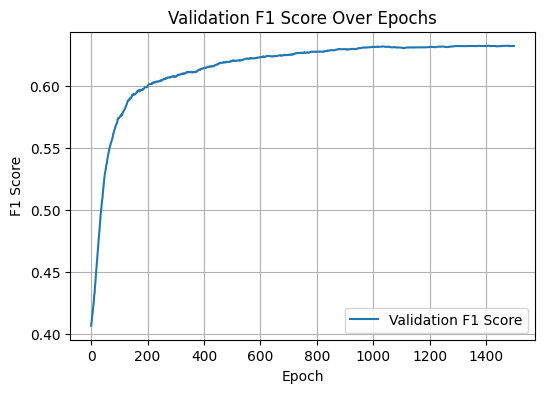

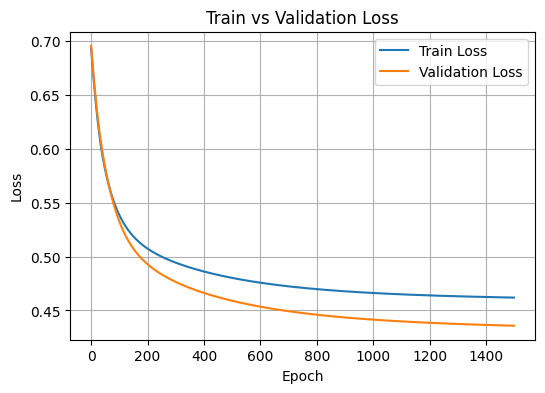


테스트 결과:
Accuracy : 0.8362
Precision: 0.6541
Recall   : 0.6290
F1 Score : 0.6413


In [ ]:
# 1. 모델 훈련
model = train_logistic_regression(
    loader,
    num_epochs=1500, #1500 이상으로는 큰 차이가 없었습니다.
    learning_rate=1e-3, #1e-4로 하면 오히려 학습률이 떨어졌습니다.
    use_class_weights=True  # 추가
)

# 2. 모델 테스트
test_logistic_regression(model, loader)

# 그러나 결과값은 가중치를 준것과 안준것의 차이는 미미헀습니다.

In [ ]:
# 1. 데이터 로드
# 2. 결측치가 Status=1에만 있는 컬럼 제거
# 3. 이상치 제거
# 4. 특성과 라벨 분리
# 5. 인코딩
# 6. 🧩 **데이터 분할**
# 7. 🧪 **X_train 기준 결측치 보강**
# 8. 🔧 **X_train 기준 스케일링**
# 9. 오버/언더샘플링 (X_train에만)
# 10. 모델 학습 및 평가


## 결정트리 모델 정의

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import graphviz

class SklearnDecisionTreeClassifier:
    def __init__(self, feature_names, max_depth, min_sample_leaf, random_state, class_weight=None):
        self.feature_names = feature_names
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.random_state = random_state
        self.class_weight = class_weight

        self.classifier = tree.DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_leaf=self.min_sample_leaf,
            random_state=self.random_state,
            class_weight=self.class_weight  # 외부에서 지정 가능
        )

    def __call__(self, data):
        return self.classifier.predict(data)

    def train_model(self, train_data, train_label):
        self.classifier.fit(train_data, train_label)

    def test_model(self, test_data, test_label, label="Test"):
        pred = self.classifier.predict(test_data)
        accuracy = accuracy_score(test_label, pred)
        precision = precision_score(test_label, pred)
        recall = recall_score(test_label, pred)
        f1_measure = f1_score(test_label, pred)

        print(f'\n [{label}] 결과:')
        print(f'Accuracy : {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall   : {recall:.4f}')
        print(f'F1 Score : {f1_measure:.4f}')

    def show_tree(self):
        plt.figure(figsize=(20, 10))
        tree.plot_tree(self.classifier, feature_names=self.feature_names, filled=True)
        plt.show()

    def show_customized_tree(self):
        dot_data = tree.export_graphviz(
            self.classifier,
            out_file=None,
            feature_names=self.feature_names,
            class_names=['0', '1'],
            filled=True,
            rounded=True,
            special_characters=True
        )
        graph = graphviz.Source(dot_data)
        graph.view()


## 결정트리 실행코드


 [Validation] 결과:
Accuracy : 0.9805
Precision: 0.9235
Recall   : 0.9990
F1 Score : 0.9598

 [Test] 결과:
Accuracy : 0.9812
Precision: 0.9262
Recall   : 0.9990
F1 Score : 0.9612


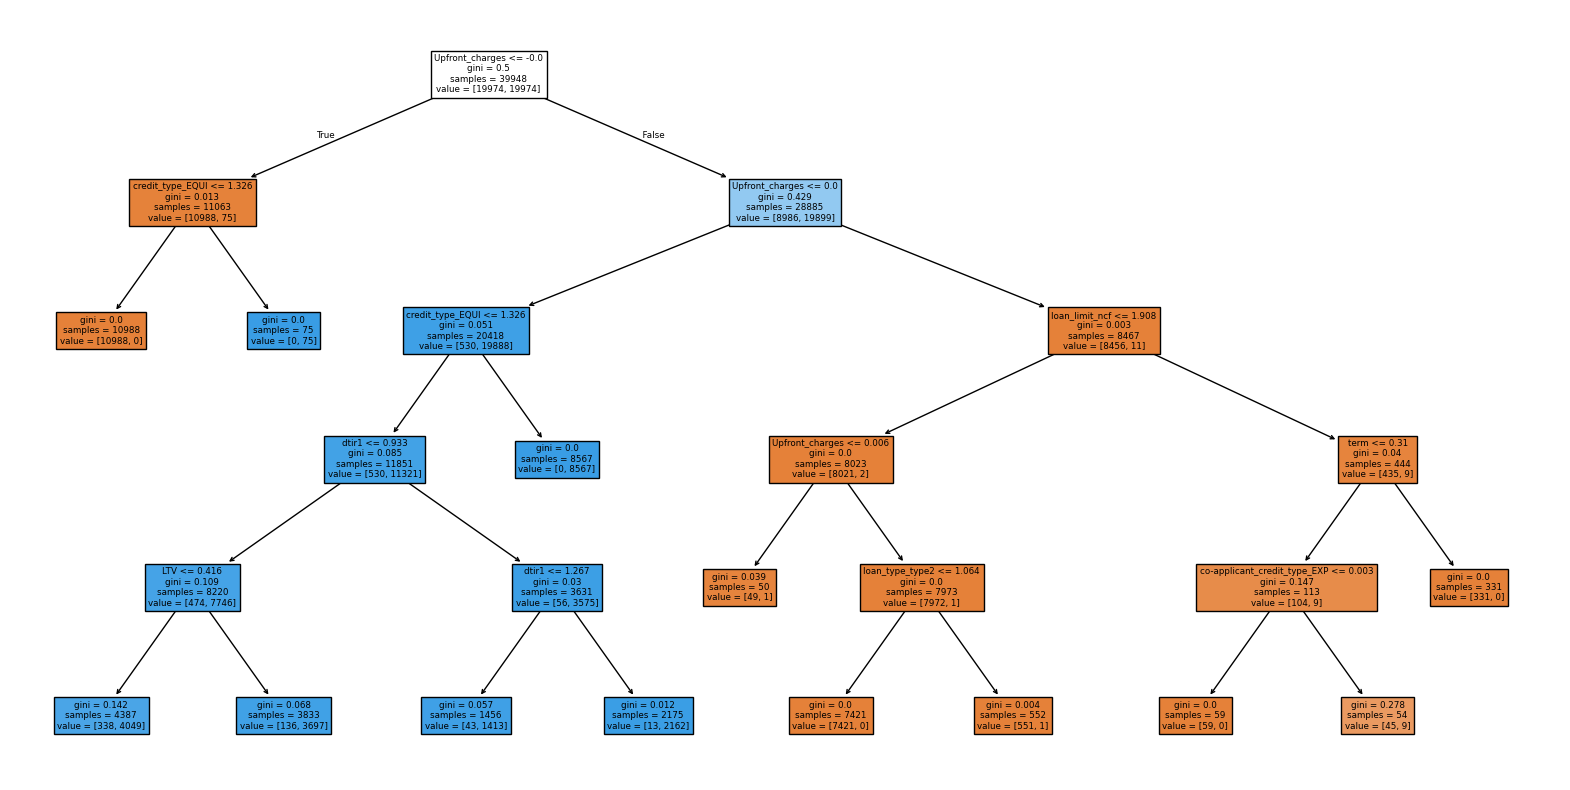

In [ ]:
# 모델 초기화 및 학습
dt_model = SklearnDecisionTreeClassifier(
    feature_names=loader.encoded_columns,
    max_depth=5,
    min_sample_leaf=50,
    random_state=42,
    class_weight='balanced', # 클래스 가중치 -> 크게 변화하는 건 느끼지 못했습니다.
)

dt_model.train_model(loader.X_train, loader.y_train)

# 검증 평가
dt_model.test_model(loader.X_val, loader.y_val, label="Validation")

# 테스트 평가
dt_model.test_model(loader.X_test, loader.y_test, label="Test")

# 트리 시각화
dt_model.show_tree()  # 또는 dt_model.show_customized_tree()


## 랜덤 포레스트 모델 정의

In [ ]:
class SklearnRandomForestClassifier:
    def __init__(self, feature_names, n_estimators=100, max_depth=None, visualize_feature=10, random_state=42, class_weight=None):
        self.feature_names = feature_names
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.visualize_feature = visualize_feature
        self.random_state = random_state
        self.class_weight = class_weight

        self.classifier = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            bootstrap=True,
            max_features='sqrt',
            class_weight=self.class_weight,
            random_state=self.random_state
        )

    def __call__(self, data):
        return self.classifier.predict(data)

    def train_model(self, train_data, train_label):
        self.classifier.fit(train_data, train_label)

    def evaluate_model(self, data, label, dataset_name="Test"):
        pred = self.classifier.predict(data)
        accuracy = accuracy_score(label, pred)
        precision = precision_score(label, pred)
        recall = recall_score(label, pred)
        f1_measure = f1_score(label, pred)

        print(f"[{dataset_name}] 결과:")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1 Score : {f1_measure:.4f}")
        print("-" * 40)

    def show_trees(self, count=1):
        for idx, decision_tree in enumerate(self.classifier.estimators_[:count]):
            plt.figure(figsize=(20, 10))
            tree.plot_tree(decision_tree, filled=True, feature_names=self.feature_names)
            plt.title(f"Tree #{idx+1}")
            plt.show()

    def plot_feature_importance(self):
        importances = self.classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_features = indices[:self.visualize_feature]
        plt.figure(figsize=(10, 5))
        plt.title(f"Top {self.visualize_feature} Important Features")
        plt.bar(range(len(top_features)), importances[top_features], align="center")
        plt.xticks(range(len(top_features)), [self.feature_names[i] for i in top_features], rotation=90)
        plt.tight_layout()
        plt.show()


## 랜덤포레스트 실습 코드

[Validation] 결과:
Accuracy : 0.9808
Precision: 0.9243
Recall   : 0.9996
F1 Score : 0.9605
----------------------------------------
[Test] 결과:
Accuracy : 0.9821
Precision: 0.9289
Recall   : 0.9998
F1 Score : 0.9630
----------------------------------------


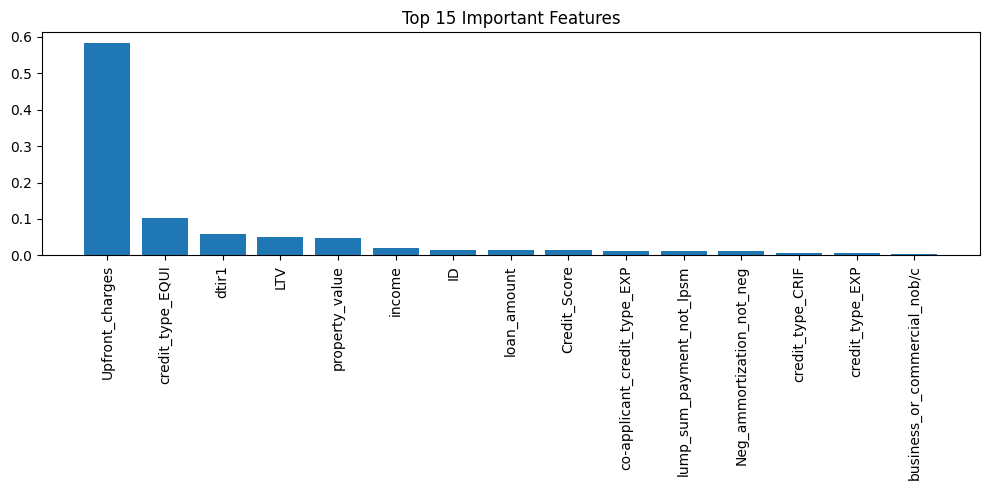

In [ ]:
# 학습/검증/테스트 데이터 준비
classification_train_data, classification_train_label = loader.X_train, loader.y_train
classification_val_data, classification_val_label = loader.X_val, loader.y_val
classification_test_data, classification_test_label = loader.X_test, loader.y_test

# 모델 정의
sklearn_rf_classifier = SklearnRandomForestClassifier(
    feature_names=classification_feature_names,
    n_estimators=100,
    max_depth=20,
    visualize_feature=15,
    random_state=42,
    class_weight='balanced' # 랜덤 포레스트 역시 가중치에 대해서 큰 차이는 없었습니다.
)

# 훈련
sklearn_rf_classifier.train_model(classification_train_data, classification_train_label)

# 검증 성능
sklearn_rf_classifier.evaluate_model(classification_val_data, classification_val_label, dataset_name="Validation")

# 테스트 성능
sklearn_rf_classifier.evaluate_model(classification_test_data, classification_test_label, dataset_name="Test")

# 피처 중요도 시각화
sklearn_rf_classifier.plot_feature_importance()


## XBoost 모델 정의

In [ ]:
# 2. Sklearn GBDT 모델 클래스 정의
class SklearnGradientBoostingClassifier:
    def __init__(self, feature_names, n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42):
        self.feature_names = feature_names
        self.classifier = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state
        )

    def __call__(self, data):
        return self.classifier.predict(data)

    def train_model(self, train_data, train_label, sample_weights=None):
        if sample_weights is not None:
            self.classifier.fit(train_data, train_label, sample_weight=sample_weights)
        else:
            self.classifier.fit(train_data, train_label)

    def test_model(self, data, label, dataset_name="Test"):
        pred = self.classifier.predict(data)
        acc = accuracy_score(label, pred)
        prec = precision_score(label, pred)
        rec = recall_score(label, pred)
        f1 = f1_score(label, pred)
        print(f"[{dataset_name}] Accuracy : {acc:.4f}")
        print(f"[{dataset_name}] Precision: {prec:.4f}")
        print(f"[{dataset_name}] Recall   : {rec:.4f}")
        print(f"[{dataset_name}] F1 Score : {f1:.4f}")
        print("-" * 40)

    def plot_feature_importance(self):
        importances = self.classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_features = indices[:15]

        plt.figure(figsize=(10, 5))
        plt.title("Top 15 Feature Importances (Sklearn GBDT)")
        plt.bar(range(len(top_features)), importances[top_features], align="center")
        plt.xticks(range(len(top_features)), [self.feature_names[i] for i in top_features], rotation=90)
        plt.tight_layout()
        plt.show()


# 3. XGBoost 모델 클래스 정의
class XGBoostClassifierWrapper:
    def __init__(self, feature_names, n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, scale_pos_weight=None):
        self.feature_names = feature_names
        self.scale_pos_weight = scale_pos_weight
        self.classifier = xgb.XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=random_state,
            scale_pos_weight=self.scale_pos_weight  # 불균형 클래스 비율 적용

        )

    def __call__(self, data):
        return self.classifier.predict(data)

    def train_model(self, train_data, train_label):
        self.classifier.fit(train_data, train_label)

    def test_model(self, data, label, dataset_name="Test"):
        pred = self.classifier.predict(data)
        acc = accuracy_score(label, pred)
        prec = precision_score(label, pred)
        rec = recall_score(label, pred)
        f1 = f1_score(label, pred)
        print(f"[{dataset_name}] Accuracy : {acc:.4f}")
        print(f"[{dataset_name}] Precision: {prec:.4f}")
        print(f"[{dataset_name}] Recall   : {rec:.4f}")
        print(f"[{dataset_name}] F1 Score : {f1:.4f}")
        print("-" * 40)

    def plot_feature_importance(self):
        xgb.plot_importance(self.classifier, importance_type="weight", max_num_features=15)
        plt.title("Top 15 Feature Importances (XGBoost)")
        plt.tight_layout()
        plt.show()

# 4. 학습/검증/테스트 데이터 할당
classification_train_data = loader.X_train
classification_train_label = loader.y_train
classification_val_data = loader.X_val
classification_val_label = loader.y_val
classification_test_data = loader.X_test
classification_test_label = loader.y_test
classification_feature_names = loader.encoded_columns

# 5. 모델 하이퍼파라미터 설정
n_estimators = 100
learning_rate = 0.1
max_depth = 4
random_state = 42

## XBoost 모델 평가

[Validation] Accuracy : 0.9812
[Validation] Precision: 0.9263
[Validation] Recall   : 0.9988
[Validation] F1 Score : 0.9612
----------------------------------------
[Test] Accuracy : 0.9823
[Test] Precision: 0.9295
[Test] Recall   : 0.9997
[Test] F1 Score : 0.9633
----------------------------------------


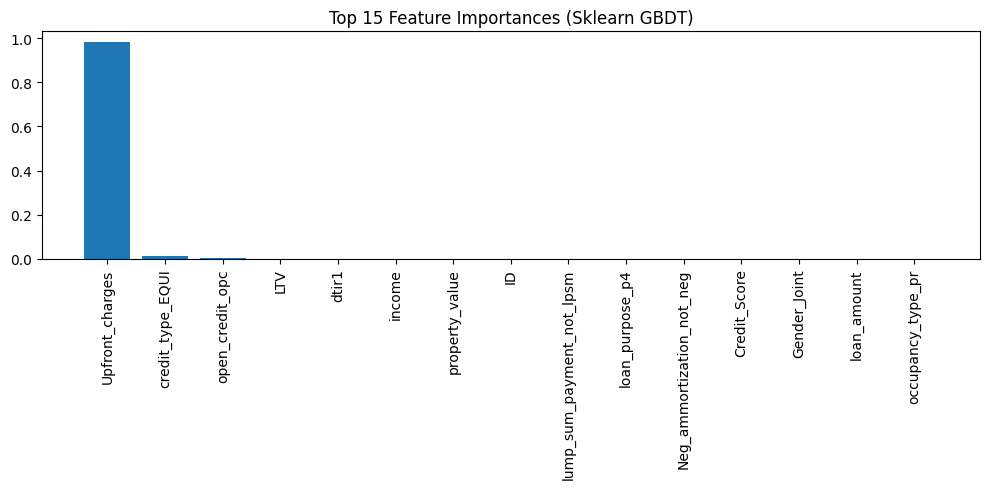

XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:26:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Validation] Accuracy : 0.9808
[Validation] Precision: 0.9244
[Validation] Recall   : 0.9994
[Validation] F1 Score : 0.9605
----------------------------------------
[Test] Accuracy : 0.9820
[Test] Precision: 0.9284
[Test] Recall   : 0.9998
[Test] F1 Score : 0.9628
----------------------------------------


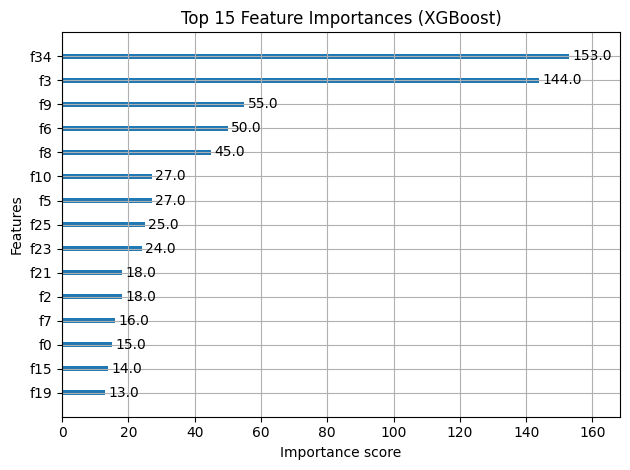

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# 1. Sklearn GBDT용 sample_weight 계산
sample_weights = compute_sample_weight(class_weight='balanced', y=classification_train_label)

# 2. XGBoost용 scale_pos_weight 계산
neg, pos = np.bincount(classification_train_label)
scale_pos_weight = neg / pos  # 예: 9000 / 1000 = 9.0


# Sklearn GBDT 학습 및 평가
sklearn_gbdt_classifier = SklearnGradientBoostingClassifier(
    classification_feature_names, n_estimators, learning_rate, max_depth, random_state
)

# 가중치 적용하여 학습
sklearn_gbdt_classifier.train_model(
    classification_train_data,
    classification_train_label,
    sample_weights=sample_weights
)

# 성능 평가
sklearn_gbdt_classifier.test_model(classification_val_data, classification_val_label, dataset_name="Validation")
sklearn_gbdt_classifier.test_model(classification_test_data, classification_test_label, dataset_name="Test")
sklearn_gbdt_classifier.plot_feature_importance()

# XGBoost 학습 및 평가
print("XGBoost")
xgboost_classifier = XGBoostClassifierWrapper(
    classification_feature_names,
    n_estimators,
    learning_rate,
    max_depth,
    random_state,
    scale_pos_weight=scale_pos_weight  # 가중치 부여 부분
)

xgboost_classifier.train_model(classification_train_data, classification_train_label)
xgboost_classifier.test_model(classification_val_data, classification_val_label, dataset_name="Validation")
xgboost_classifier.test_model(classification_test_data, classification_test_label, dataset_name="Test")
xgboost_classifier.plot_feature_importance()

## 궁금한점
### 지금 전처리를 이렇게 했는데 맞는 과정인지? (잘못되었다면 코멘트 부탁드립니다)
### 로지스틱 부분에서만 왜 평가 점수가 낮은건지?
### 나머지 모델에서는 평가가 너무 높게 나오는데 맞는건지?
### 틀렸다면 과적합이 된건지? 아니면 어떤점이 잘못되었는지?
### 현업에서도 csv 파일로 진행을 많이 하는지?
### 이런 데이터들이 실시간으로 들어온다면 데이터 처리는 어떤 방향으로 하는지? (예를 들어 1일, 1주일, 한달의 데이터를 모으고 학습을 진행해야하는건지 등...)